# Data Cleaning

## First Look

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from matplotlib.axes import Axes
from matplotlib.figure import Figure 
from typing import Optional, Dict, Any

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels

In [2]:
import statsmodels
print(statsmodels.__version__)

0.14.6


In [3]:
df_collisions = pd.read_csv(
    "../data/Motor_Vehicle_Collisions_-_Crashes_20260104.csv",
    dtype={"ZIP CODE": "string","BOROUGH": "string"},   
    low_memory=False               
)

In [4]:
df_collisions.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,<NA>,<NA>,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,<NA>,<NA>,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230,"40,62179","-73,970024","(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,<NA>,<NA>,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,<NA>,<NA>,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [5]:
row_count = df_collisions.shape[0]
col_count = df_collisions.shape[1]

print("Number of rows", row_count)
print("Number of columns", col_count)

Number of rows 2232154
Number of columns 29


In [6]:
print("Features")
df_collisions.columns

Features


Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [7]:
relevant_features = ['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE','LONGITUDE', 'LOCATION','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED']
df_collisions = df_collisions[relevant_features]

relevant_rows = df_collisions["NUMBER OF CYCLIST INJURED"] > 0
df_collisions = df_collisions[relevant_rows]

row_count_new = df_collisions.shape[0]
col_count_new = df_collisions.shape[1]

print("Number of rows", row_count_new)
print("Number of columns", col_count_new)

df_collisions.head()

Number of rows 64535
Number of columns 9


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
33,12/14/2021,12:54,BROOKLYN,11217,"40,687534","-73,9775","(40.687534, -73.9775)",1,0
37,12/14/2021,16:25,<NA>,<NA>,"40,784615","-73,953964","(40.784615, -73.953964)",1,0
62,04/24/2022,15:35,MANHATTAN,10019,"40,767242","-73,986206","(40.767242, -73.986206)",1,0
77,12/09/2021,20:20,BROOKLYN,11223,"40,59207","-73,96299","(40.59207, -73.96299)",1,0
83,12/09/2021,23:15,BROOKLYN,11218,"40,640835","-73,98967","(40.640835, -73.98967)",1,0


In [8]:
df_collisions.isnull().sum()

CRASH DATE                       0
CRASH TIME                       0
BOROUGH                      13595
ZIP CODE                     13597
LATITUDE                      4271
LONGITUDE                     4271
LOCATION                      4271
NUMBER OF CYCLIST INJURED        0
NUMBER OF CYCLIST KILLED         0
dtype: int64

## Data Types

In [9]:
df_collisions.dtypes

CRASH DATE                           object
CRASH TIME                           object
BOROUGH                      string[python]
ZIP CODE                     string[python]
LATITUDE                             object
LONGITUDE                            object
LOCATION                             object
NUMBER OF CYCLIST INJURED             int64
NUMBER OF CYCLIST KILLED              int64
dtype: object

In [10]:
for col in ["LATITUDE", "LONGITUDE"]:
    df_collisions[col] = pd.to_numeric(
        df_collisions[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip(),
        errors="coerce"   # anything non-numeric → NaN (float)
    )

In [11]:
df_collisions.dtypes

CRASH DATE                           object
CRASH TIME                           object
BOROUGH                      string[python]
ZIP CODE                     string[python]
LATITUDE                            float64
LONGITUDE                           float64
LOCATION                             object
NUMBER OF CYCLIST INJURED             int64
NUMBER OF CYCLIST KILLED              int64
dtype: object

In [12]:
df_collisions["CRASH_DATETIME"] = pd.to_datetime(
    df_collisions["CRASH DATE"] + " " + df_collisions["CRASH TIME"],
    format="%m/%d/%Y %H:%M",
    errors="raise"
)
df_collisions.drop(columns=["CRASH DATE", "CRASH TIME"], inplace=True)

In [13]:
df_collisions.dtypes

BOROUGH                      string[python]
ZIP CODE                     string[python]
LATITUDE                            float64
LONGITUDE                           float64
LOCATION                             object
NUMBER OF CYCLIST INJURED             int64
NUMBER OF CYCLIST KILLED              int64
CRASH_DATETIME               datetime64[ns]
dtype: object

In [14]:
df_collisions[['LATITUDE', 'LONGITUDE','ZIP CODE']].sample(50, random_state=2)

,LATITUDE,LONGITUDE,ZIP CODE
2143301,40.689865,-73.951460,11205
2140332,40.771053,-73.987144,10023
193153,40.718792,-73.989020,10002
1687210,NaN,NaN,<NA>
216131,40.744778,-73.975890,10016
1647157,40.679310,-73.791709,11436
2207602,40.729717,-73.998860,10012
2046931,40.714947,-74.009682,10007
1741675,40.787064,-73.941936,10029
17381,40.775906,-73.920525,11102


## Clean and infer LAT/Long

In [15]:
#rough outlines of New York
min_lat, max_lat = 40.4, 41.0
min_long, max_long = -74.3, -73.6

# Filter rows where EITHER lat or long is out of bounds
mask = (
    (df_collisions["LATITUDE"] < min_lat) |
    (df_collisions["LATITUDE"] > max_lat) |
    (df_collisions["LONGITUDE"] < min_long) |
    (df_collisions["LONGITUDE"] > max_long)
)

# Get counts of each unique (lat, long) pair
bad_coord_counts = (
    df_collisions.loc[mask, ["LATITUDE", "LONGITUDE","LOCATION"]]
    .value_counts()
    .sort_index()
)

bad_coord_counts

LATITUDE  LONGITUDE  LOCATION      
0.0       0.0            (0.0, 0.0)    314
                     (0.0, 0.0)         62
Name: count, dtype: int64

- fil the double zero rows with Nans and delete the other ones

In [16]:
zero_mask = (
    (df_collisions["LATITUDE"] == 0) &
    (df_collisions["LONGITUDE"] == 0)
)

df_collisions.loc[zero_mask, ["LATITUDE","LONGITUDE","LOCATION"]] = np.nan

bad_mask = (
    (df_collisions["LATITUDE"] < min_lat) |
    (df_collisions["LATITUDE"] > max_lat) |
    (df_collisions["LONGITUDE"] < min_long) |
    (df_collisions["LONGITUDE"] > max_long)
)

df_collisions = df_collisions.loc[~bad_mask].copy()

In [17]:
missing_count = df_collisions.isnull().sum()
missing_percent = (missing_count / len(df_collisions)) * 100

missing_df = pd.DataFrame({
    'missing_count': missing_count,
    'total_rows': df_collisions.shape[0],
    'missing_percent': missing_percent.round(2)
})

print(missing_df)
del missing_df

                           missing_count  total_rows  missing_percent
BOROUGH                            13595       64535            21.07
ZIP CODE                           13597       64535            21.07
LATITUDE                            4647       64535             7.20
LONGITUDE                           4647       64535             7.20
LOCATION                            4647       64535             7.20
NUMBER OF CYCLIST INJURED              0       64535             0.00
NUMBER OF CYCLIST KILLED               0       64535             0.00
CRASH_DATETIME                         0       64535             0.00


In [18]:
lat = df_collisions['LATITUDE'].isna()
lon = df_collisions['LONGITUDE'].isna()
location = df_collisions['LOCATION'].isna()

print("All missing:", (lat & lon & location).sum())
print("At least one lat/long missing but not location :", (~(lat & lon) & location).sum())

All missing: 4647
At least one lat/long missing but not location : 0


- if one of the three is missing then all are .... location is useless

In [19]:
df_collisions.drop(columns=["LOCATION"], inplace=True)

In [20]:
loc_missing = df_collisions["LATITUDE"].isna()
borough_present = df_collisions["BOROUGH"].notna()
zip_present = df_collisions["ZIP CODE"].notna()

print("LOCATION missing & BOROUGH present:", (loc_missing & borough_present).sum())
print("LOCATION missing & ZIP present:", (loc_missing & zip_present).sum())
print("LOCATION missing & BOROUGH or ZIP present:", (loc_missing & (borough_present | zip_present)).sum())

LOCATION missing & BOROUGH present: 1380
LOCATION missing & ZIP present: 1380
LOCATION missing & BOROUGH or ZIP present: 1380


In [21]:
#fast look at Borough
df_collisions["BOROUGH"].value_counts(dropna=False)

BOROUGH
BROOKLYN         19651
MANHATTAN        15466
<NA>             13595
QUEENS            9904
BRONX             5296
STATEN ISLAND      623
Name: count, dtype: Int64

- infer Lat&Long through Borough

In [22]:
for col in ["LATITUDE", "LONGITUDE"]:
    df_collisions[col] = (
        df_collisions
        .groupby("BOROUGH")[col]
        .transform(lambda s: s.fillna(s.median()))
    )

In [23]:
df_collisions.columns

Index(['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'CRASH_DATETIME'],
      dtype='object')

In [24]:
#keep only relevant features
df_collisions.drop(columns=["BOROUGH",'ZIP CODE'],inplace = True)

In [25]:
print(df_collisions.shape[0])
df_collisions.head()

64535


,LATITUDE,LONGITUDE,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,CRASH_DATETIME
33,40.687534,-73.977500,1,0,2021-12-14 12:54:00
37,NaN,NaN,1,0,2021-12-14 16:25:00
62,40.767242,-73.986206,1,0,2022-04-24 15:35:00
77,40.592070,-73.962990,1,0,2021-12-09 20:20:00
83,40.640835,-73.989670,1,0,2021-12-09 23:15:00


## EDA

In [26]:
earliest = df_collisions["CRASH_DATETIME"].min()
latest   = df_collisions["CRASH_DATETIME"].max()

print("Earliest crash:", earliest)
print("Latest crash:", latest)

Earliest crash: 2012-07-01 02:30:00
Latest crash: 2025-12-29 23:27:00


In [27]:
# --- Average crashes per day ---
daily_counts = (
    df_collisions
        .set_index("CRASH_DATETIME")
        .resample("D")
        .size()
)

avg_accidents_per_day = float(daily_counts.mean())


# --- Average crashes per hour ---
hourly_counts = (
    df_collisions
        .set_index("CRASH_DATETIME")
        .resample("H")
        .size()
)

avg_accidents_per_hour = float(hourly_counts.mean())

avg_accidents_per_day, avg_accidents_per_hour

C:\Users\felix\AppData\Local\Temp\ipykernel_30588\1799188249.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H")


(13.09026369168357, 0.5454368735103704)

C:\Users\felix\AppData\Local\Temp\ipykernel_30588\1978172923.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
C:\Users\felix\AppData\Local\Temp\ipykernel_30588\1978172923.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y")


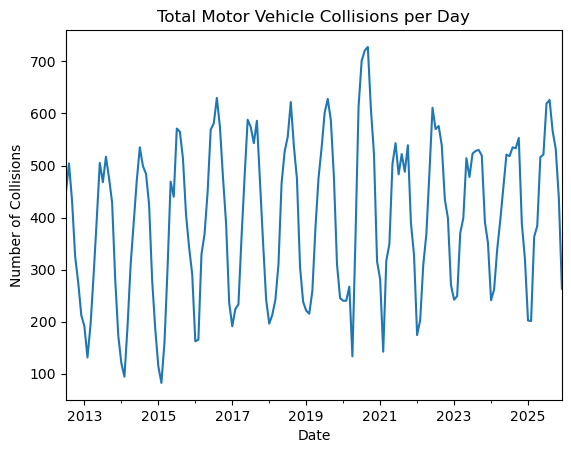

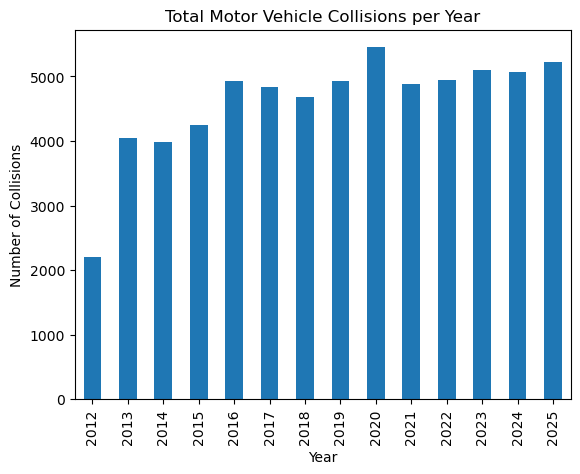

In [28]:
monthly_counts = (
    df_collisions
        .set_index("CRASH_DATETIME")
        .resample("M")
        .size()
)

yearly_counts = (
    df_collisions
        .set_index("CRASH_DATETIME")
        .resample("Y")
        .size()
)

yearly_counts.index = yearly_counts.index.year

plt.figure()
monthly_counts.plot()
plt.title("Total Motor Vehicle Collisions per Day")
plt.xlabel("Date")
plt.ylabel("Number of Collisions")
plt.show()

plt.figure()
yearly_counts.plot(kind="bar")
plt.title("Total Motor Vehicle Collisions per Year")
plt.xlabel("Year")
plt.ylabel("Number of Collisions")
plt.show()

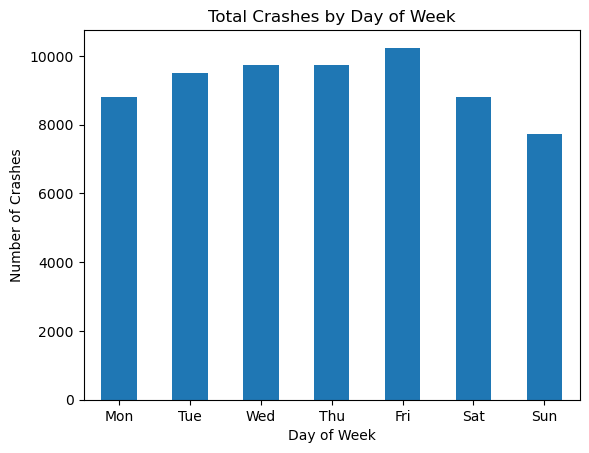

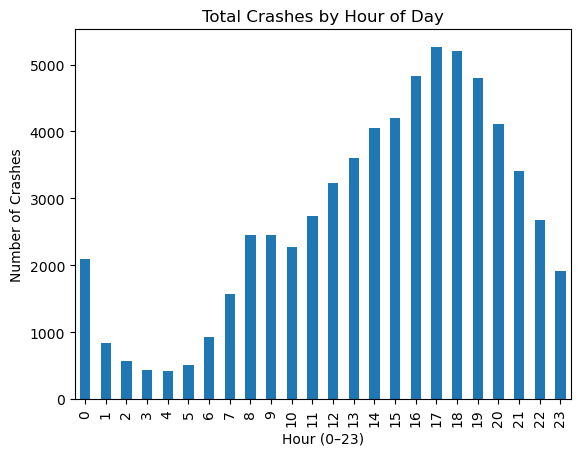

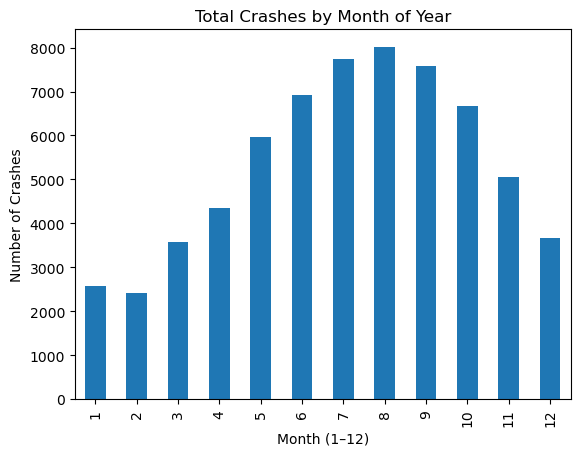

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Work on a temporary copy so we don't modify your original dataframe
df = df_collisions.copy()

# --- Day of Week ---
df["WEEKDAY"] = df["CRASH_DATETIME"].dt.dayofweek
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
weekday_counts = df["WEEKDAY"].value_counts().sort_index()

plt.figure()
weekday_counts.plot(kind="bar")
plt.xticks(range(7), weekday_labels, rotation=0)
plt.title("Total Crashes by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Crashes")
plt.show()

# --- Hour of Day ---
df["HOUR"] = df["CRASH_DATETIME"].dt.hour
hour_counts = df["HOUR"].value_counts().sort_index()

plt.figure()
hour_counts.plot(kind="bar")
plt.title("Total Crashes by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Crashes")
plt.show()

# --- Month of Year ---
df["MONTH"] = df["CRASH_DATETIME"].dt.month
month_counts = df["MONTH"].value_counts().sort_index()

plt.figure()
month_counts.plot(kind="bar")
plt.title("Total Crashes by Month of Year")
plt.xlabel("Month (1–12)")
plt.ylabel("Number of Crashes")
plt.show()

# --- Cleanup temporary df to free memory ---
del df

## Time series feature engineering

- time series = trend + seasonality + cyclic + nois
- since the accident data by the NPYPD is only updated daily (https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data) we can use running averages/lags freely when analyzing daily accidents

In [30]:
sns.set_theme(style="whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
# Create daily counts dataframe
df_daily = (
    df_collisions
        .set_index("CRASH_DATETIME")
        .resample("D")
        .size()
        .to_frame(name="accident_count")
)
df_daily.index.name = "Day"

df_daily = df_daily.to_period()

df_daily.head()
df_daily.tail()

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
#tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
#tunnel = tunnel.to_period()

,accident_count
Day,
2025-12-25,2
2025-12-26,6
2025-12-27,2
2025-12-28,3
2025-12-29,6


In [31]:
#create time feature

df_daily['Time'] = np.arange(len(df_daily.index))
df_daily.tail()

,accident_count,Time
Day,,
2025-12-25,2,4925
2025-12-26,6,4926
2025-12-27,2,4927
2025-12-28,3,4928
2025-12-29,6,4929


## Trend

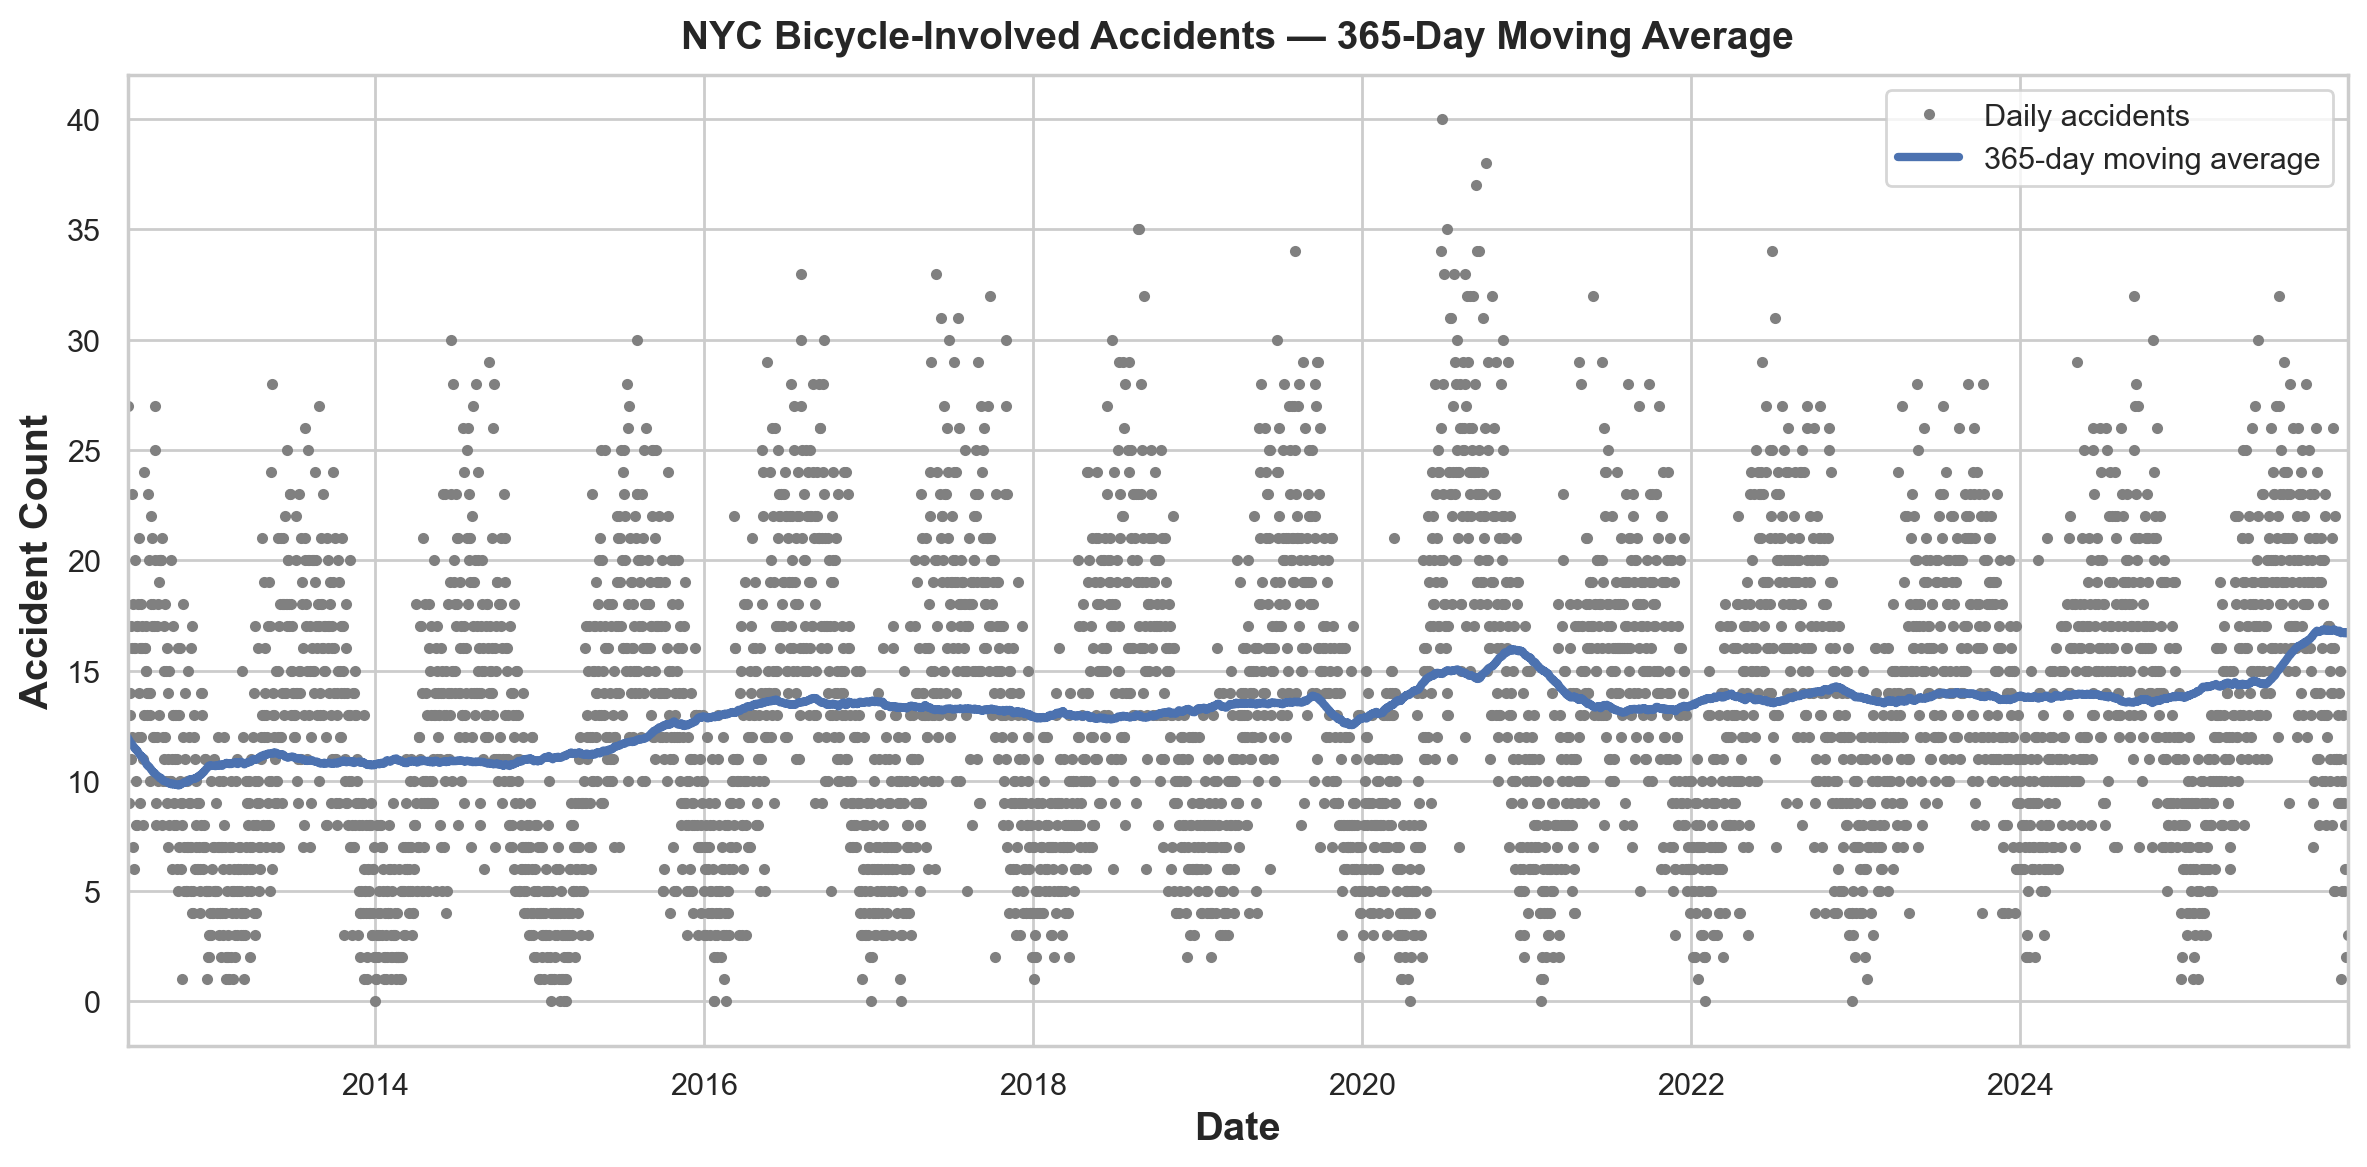

In [32]:
# 365-day centered moving average of accidents
moving_average = (
    df_daily["accident_count"]
        .rolling(
            window=365,
            center=True,
            min_periods=183   # ~ half window so edges don't disappear
        )
        .mean()
)

ax = df_daily["accident_count"].plot(
    style=".", 
    color="0.5", 
    figsize=(12,6),
    label="Daily accidents"
)

moving_average.plot(
    ax=ax, 
    linewidth=3, 
    label="365-day moving average",
    title="NYC Bicycle-Involved Accidents — 365-Day Moving Average"
)

ax.set_ylabel("Accident Count")
ax.set_xlabel("Date")
ax.legend()

- trend seems to be approcimatly linear

In [33]:
X = df_daily.loc[:, ['Time']]  # features
y = df_daily.loc[:, 'accident_count']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

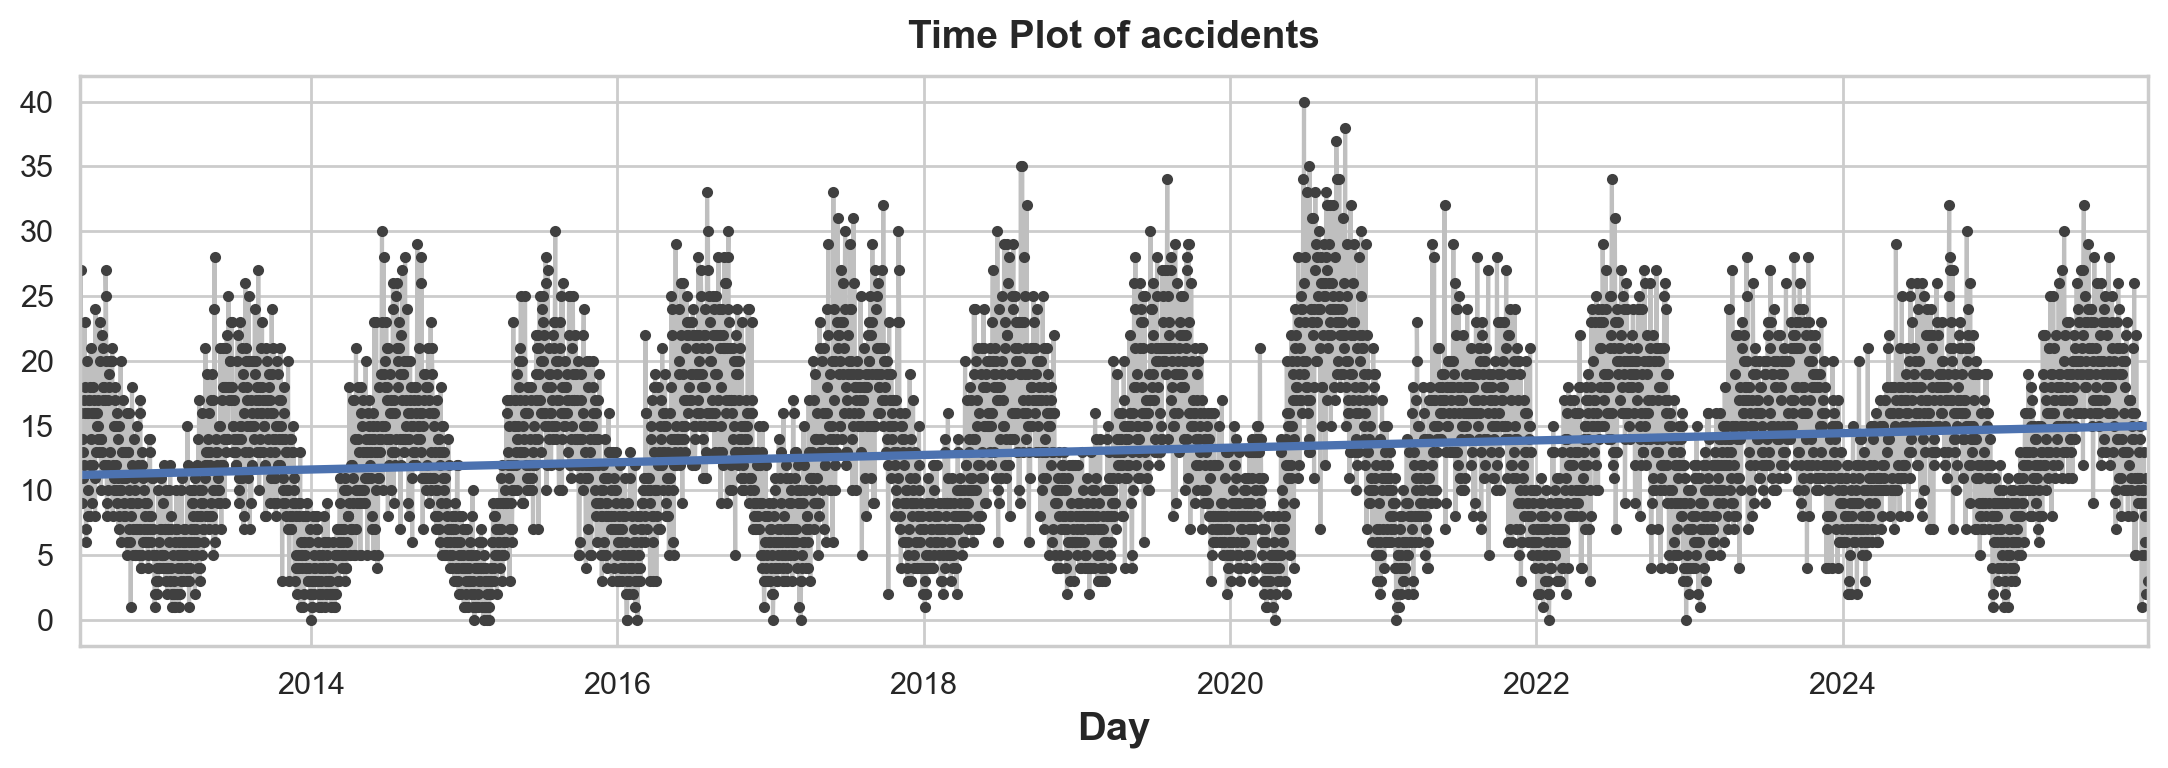

In [34]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of accidents');

In [35]:
coef = model.coef_
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficient:", coef)

Intercept: 11.197864156187022
Coefficient: [0.00076786]


### Seasonality

In [36]:
def plot_periodogram(
    ts: pd.Series,
    detrend: str = "linear",
    ax: Optional[Axes] = None
) -> Axes:
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

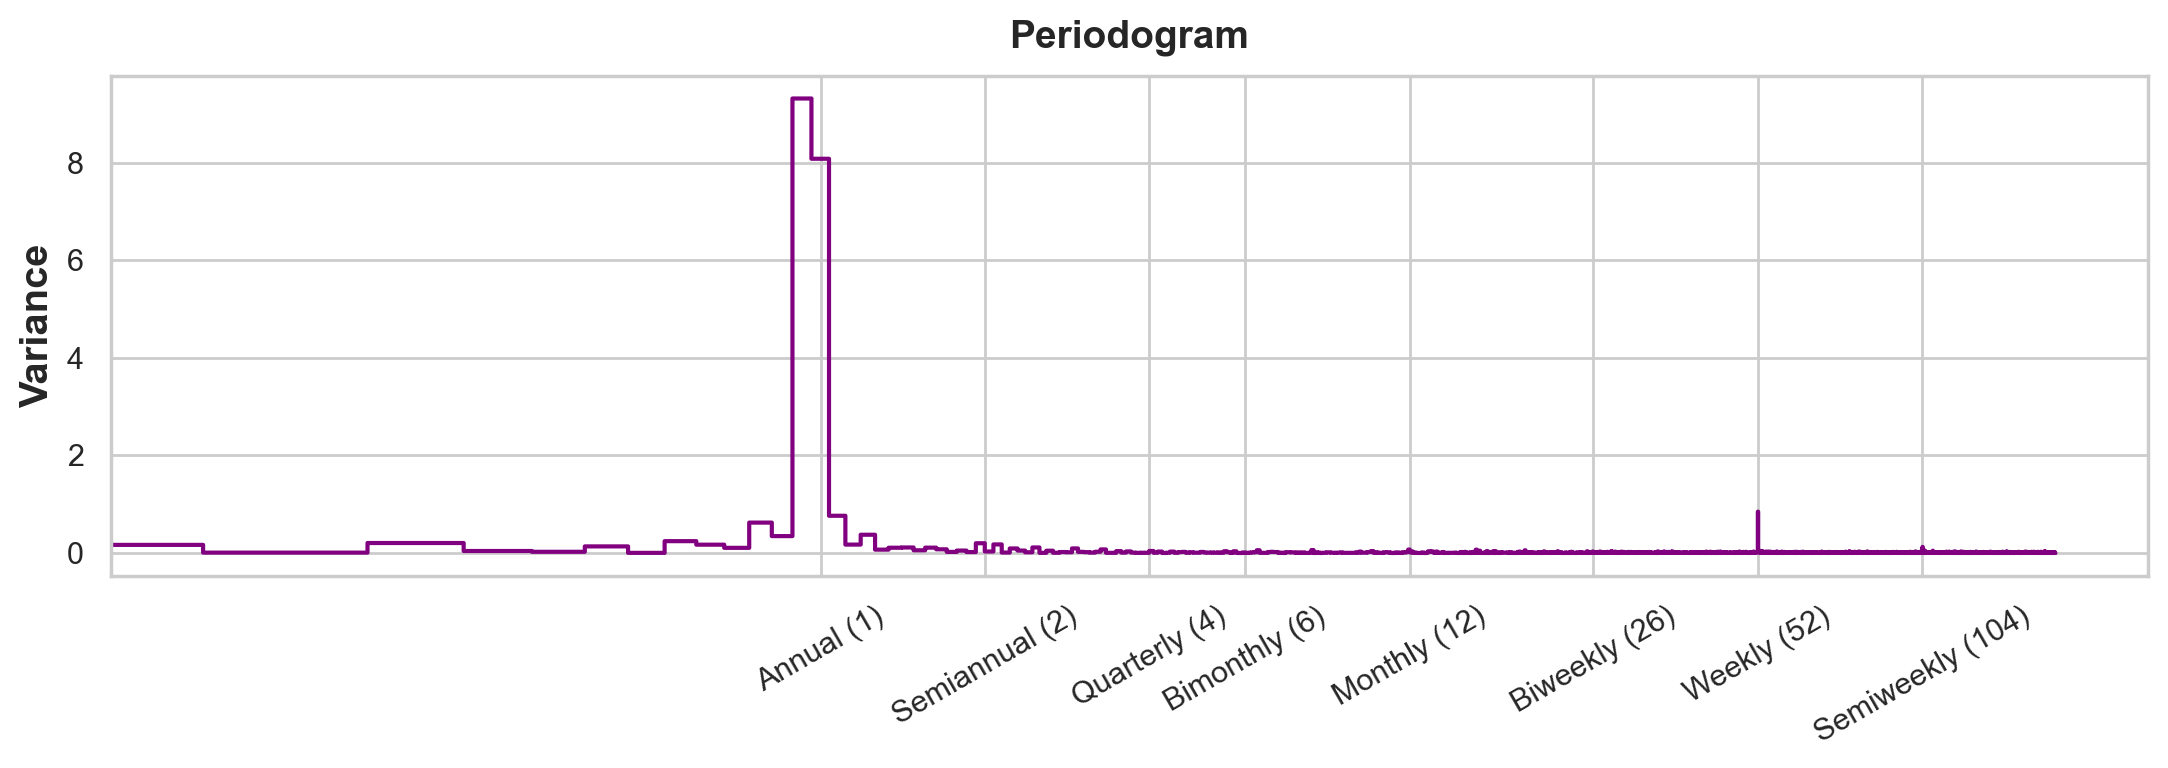

In [37]:
plot_periodogram(df_daily.accident_count)

- very strong anual season, weaker weekly season
- some small peaks around semiannual
  
-> modell annual&semi anual with Fourier features and weekly with indicators

In [48]:
fourier = CalendarFourier(freq="YE", order=2)  # 2 sin/cos pairs

dp = DeterministicProcess(
    index=df_daily.index,
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index
y = df_daily['accident_count']

In [49]:
# Create target series and data splits
y = df_daily.accident_count.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=360, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

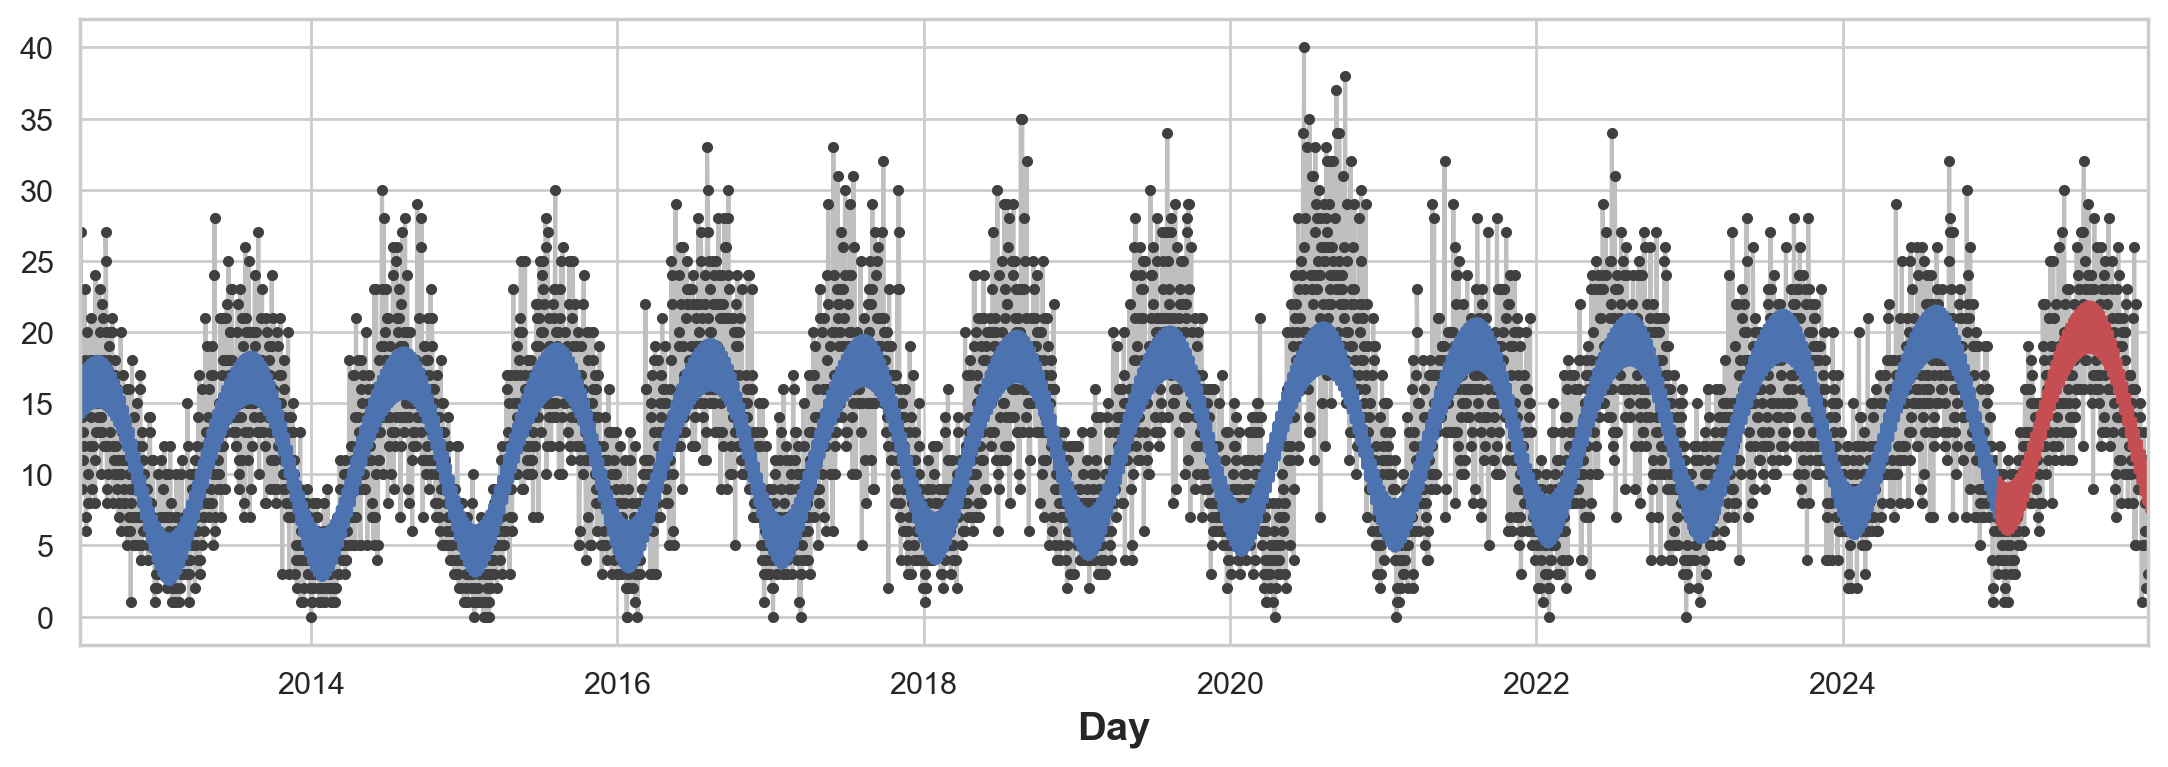

In [50]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

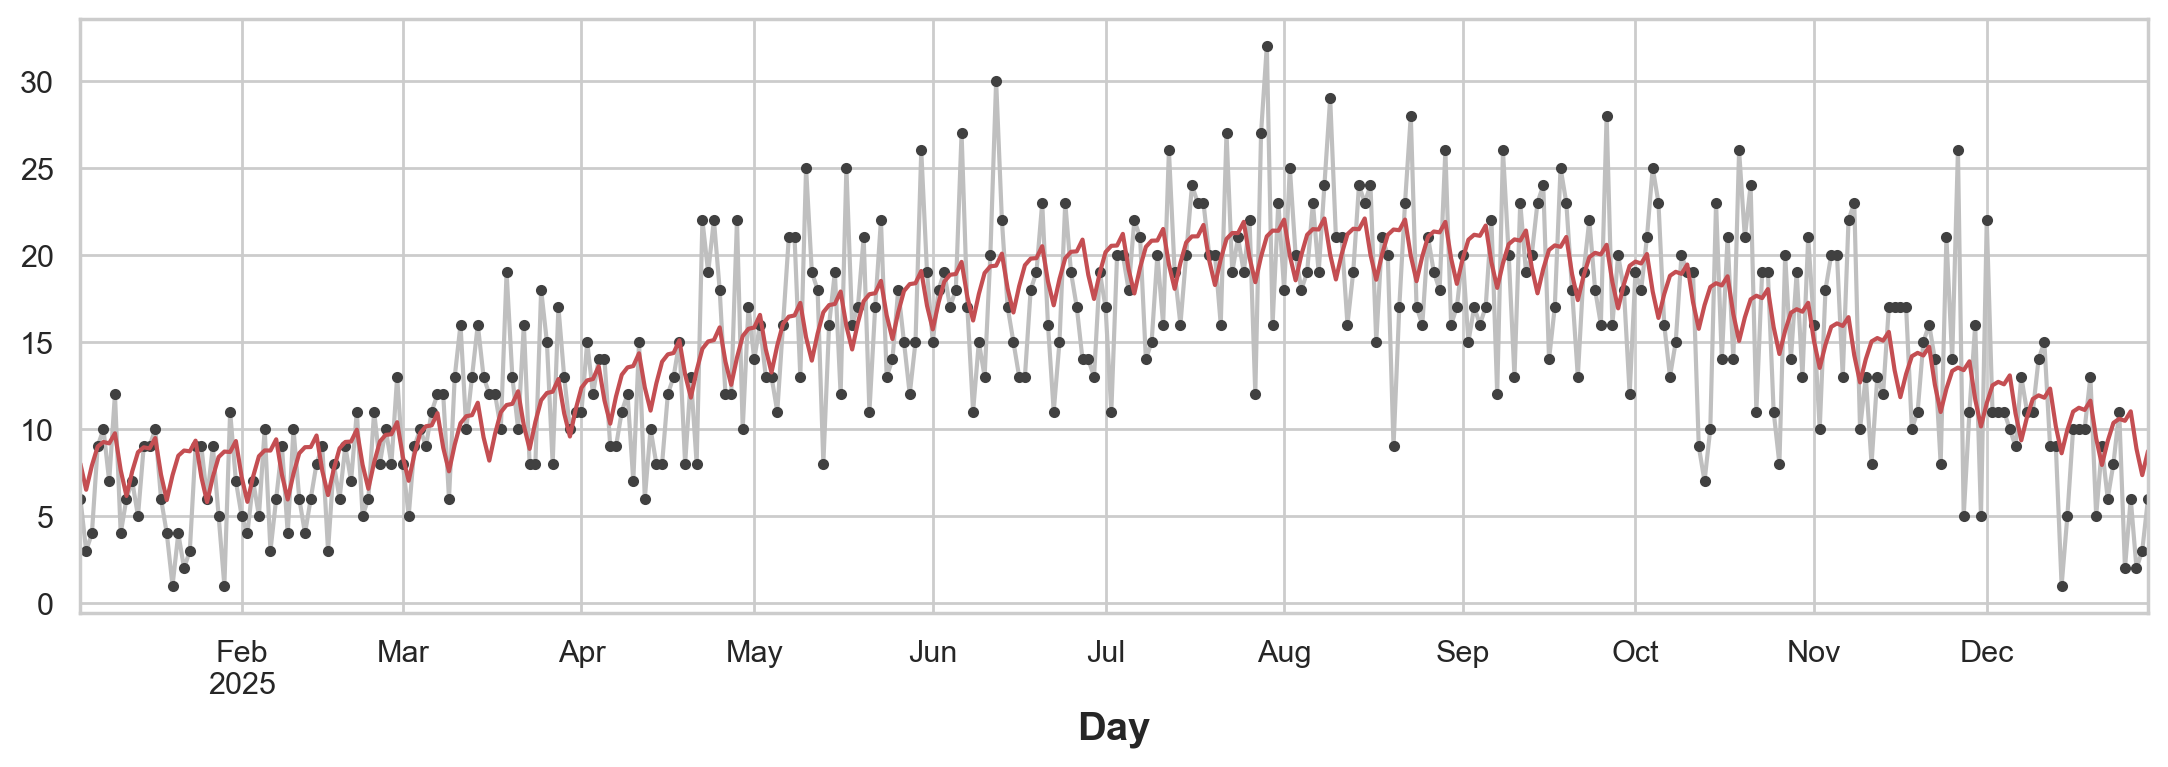

In [51]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

### Cycles

In [40]:
from __future__ import annotations

from typing import Optional, Dict, Any
import math
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.offsetbox import AnchoredText


def lagplot(
    x: pd.Series,
    y: Optional[pd.Series] = None,
    lag: int = 1,
    standardize: bool = False,
    ax: Optional[Axes] = None,
    **kwargs: Any,
) -> Axes:
    """
    Single lag plot with optional correlation annotation.
    """
    x_ = x.shift(lag)

    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()

    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x

    corr = y_.corr(x_)

    if ax is None:
        _, ax = plt.subplots()

    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color="C3")

    ax = sns.regplot(
        x=x_,
        y=y_,
        scatter_kws=scatter_kws,
        line_kws=line_kws,
        ax=ax,
        **kwargs,
    )

    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)

    return ax


def plot_lags(
    x: pd.Series,
    y: Optional[pd.Series] = None,
    lags: int = 6,
    nrows: int = 1,
    lagplot_kwargs: Optional[Dict[str, Any]] = None,
    **kwargs: Any,
) -> Figure:
    """
    Plot multiple lag plots in a grid.
    """
    if lagplot_kwargs is None:
        lagplot_kwargs = {}

    kwargs.setdefault("nrows", nrows)
    kwargs.setdefault("ncols", math.ceil(lags / nrows))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, nrows * 2 + 0.5))

    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)

    for ax, k in zip(fig.get_axes(), range(kwargs["nrows"] * kwargs["ncols"])):
        if k + 1 <= lags:
            lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")

    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    return fig

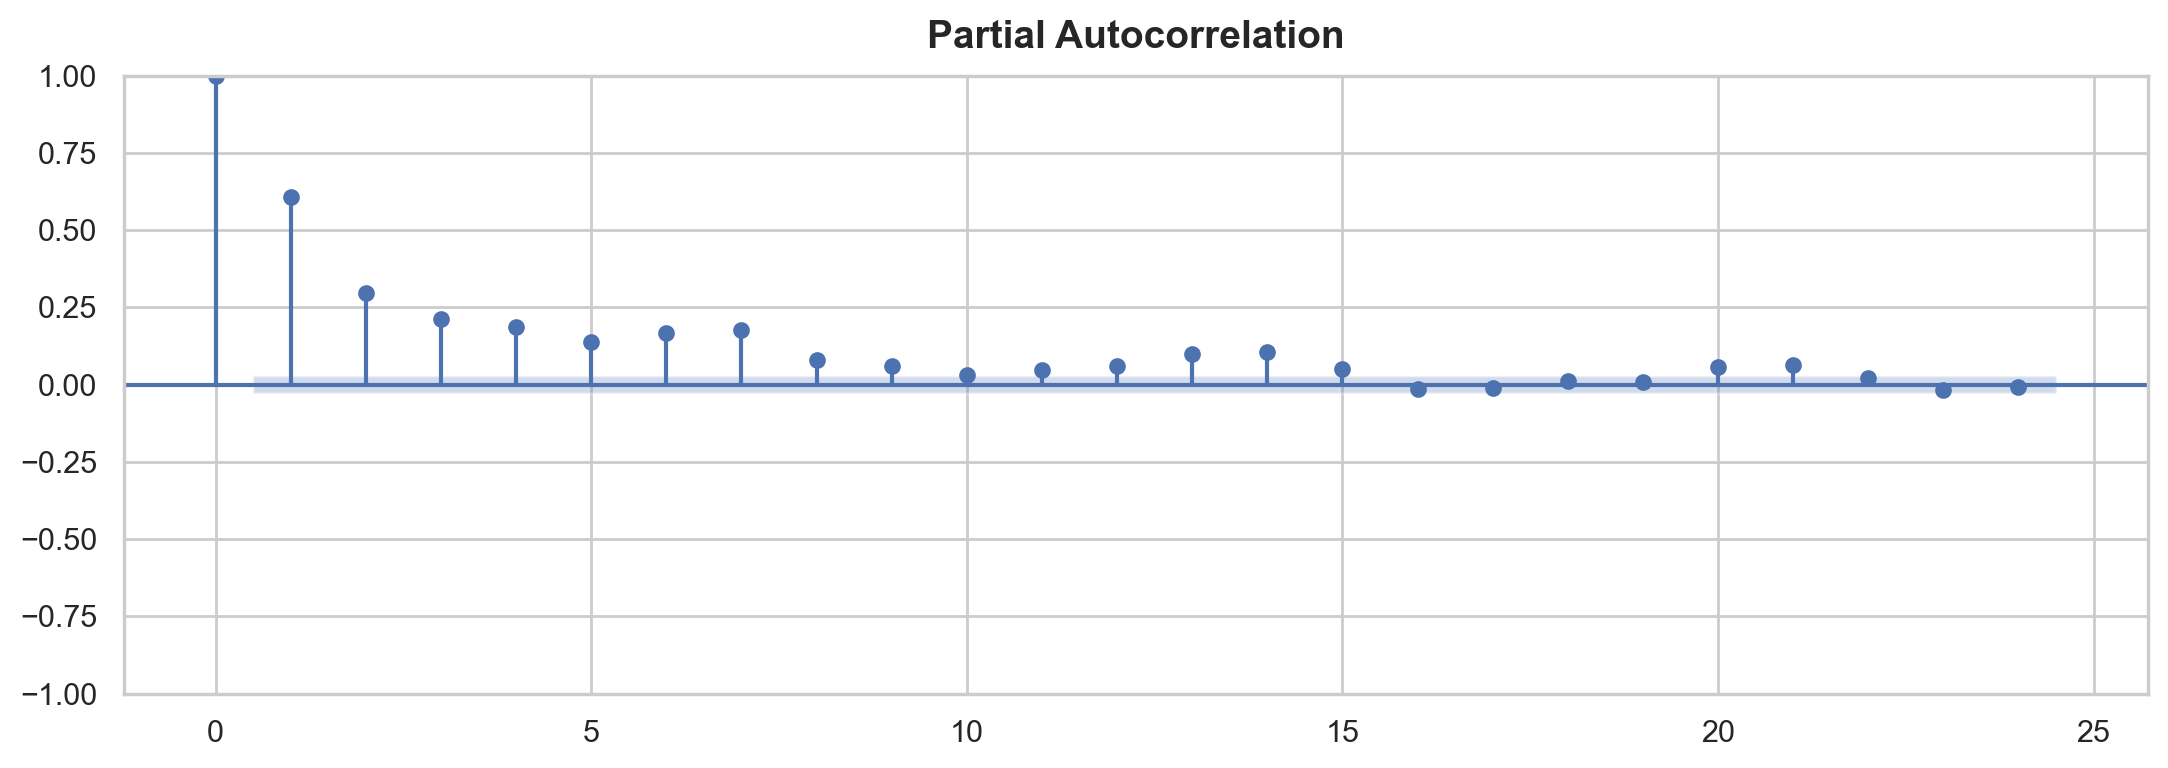

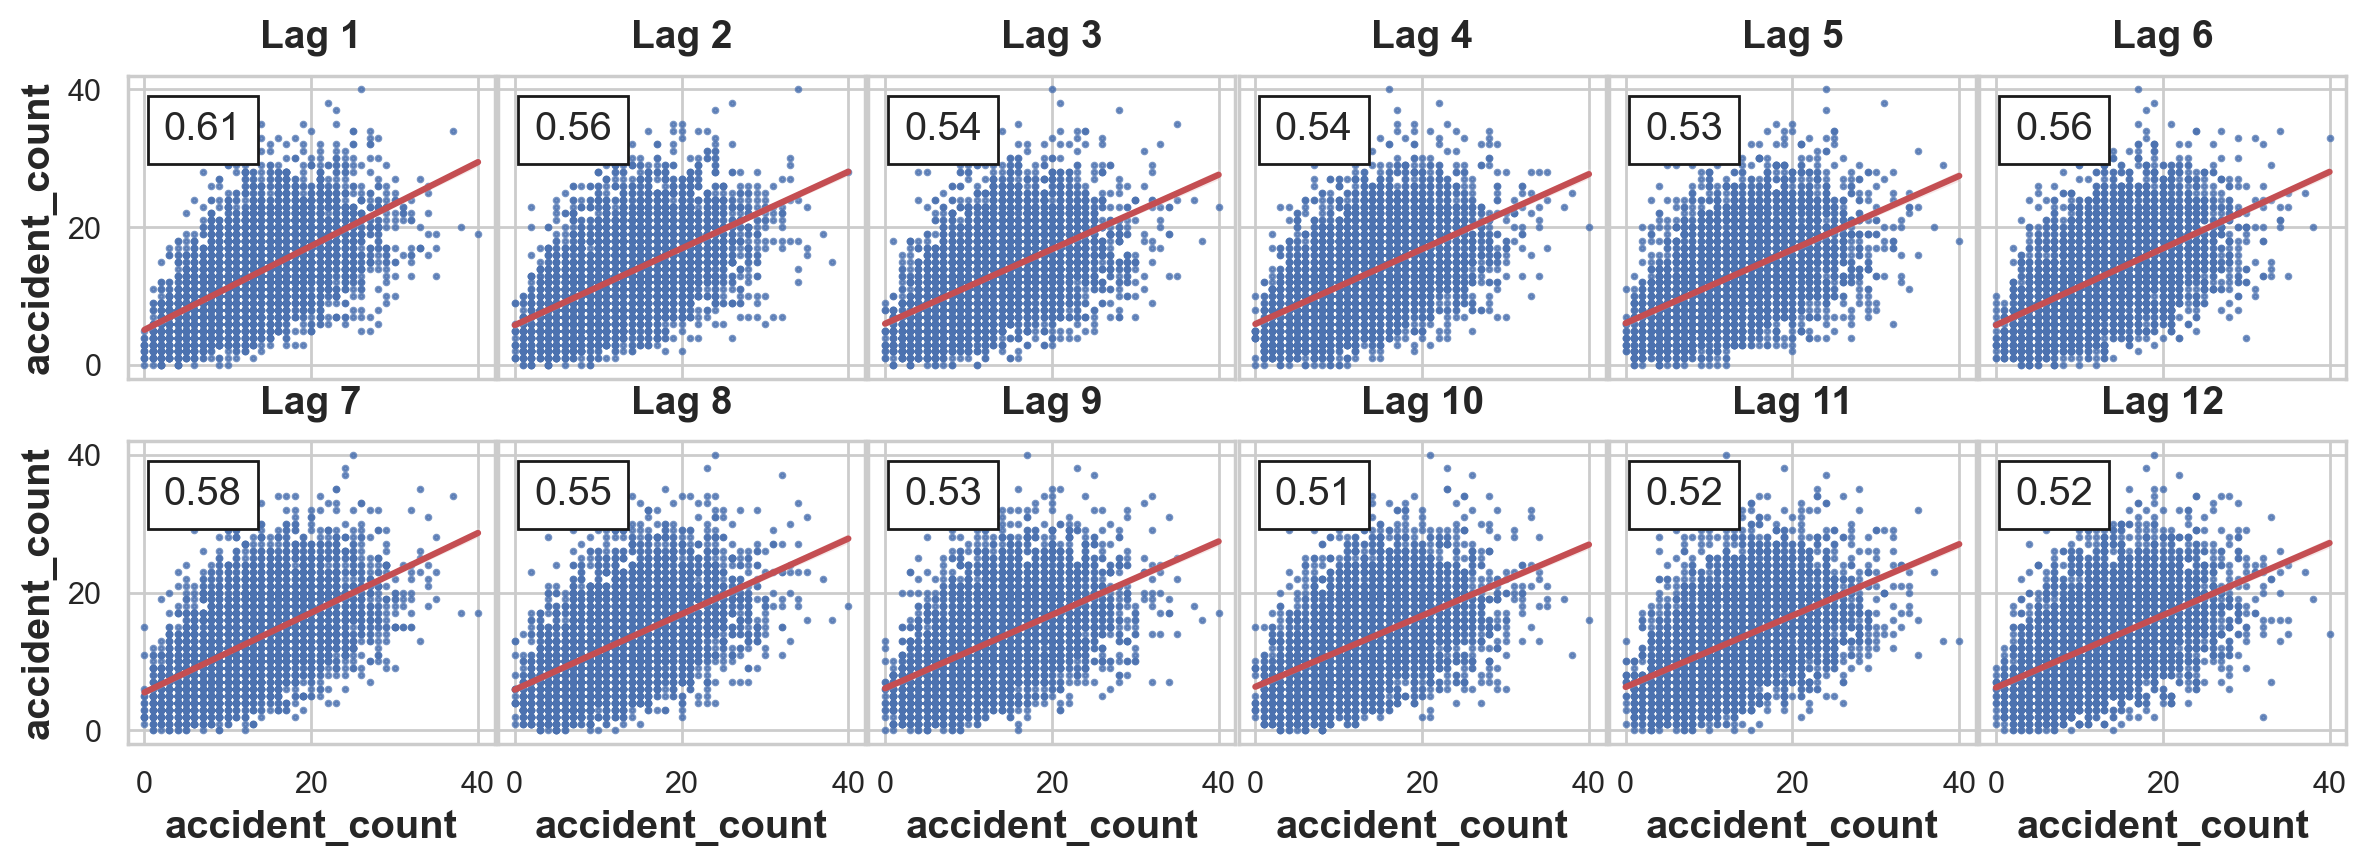

In [41]:
_ = plot_pacf(df_daily.accident_count, lags=24)
_ = plot_lags(df_daily.accident_count, lags=12, nrows=2)

- plots indicate strong correlation and that relationship between target and lags is mostly linear

In [42]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df_daily.accident_count, lags=3)
X = X.fillna(0.0)


# Create target series and data splits
y = df_daily.accident_count.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=360, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

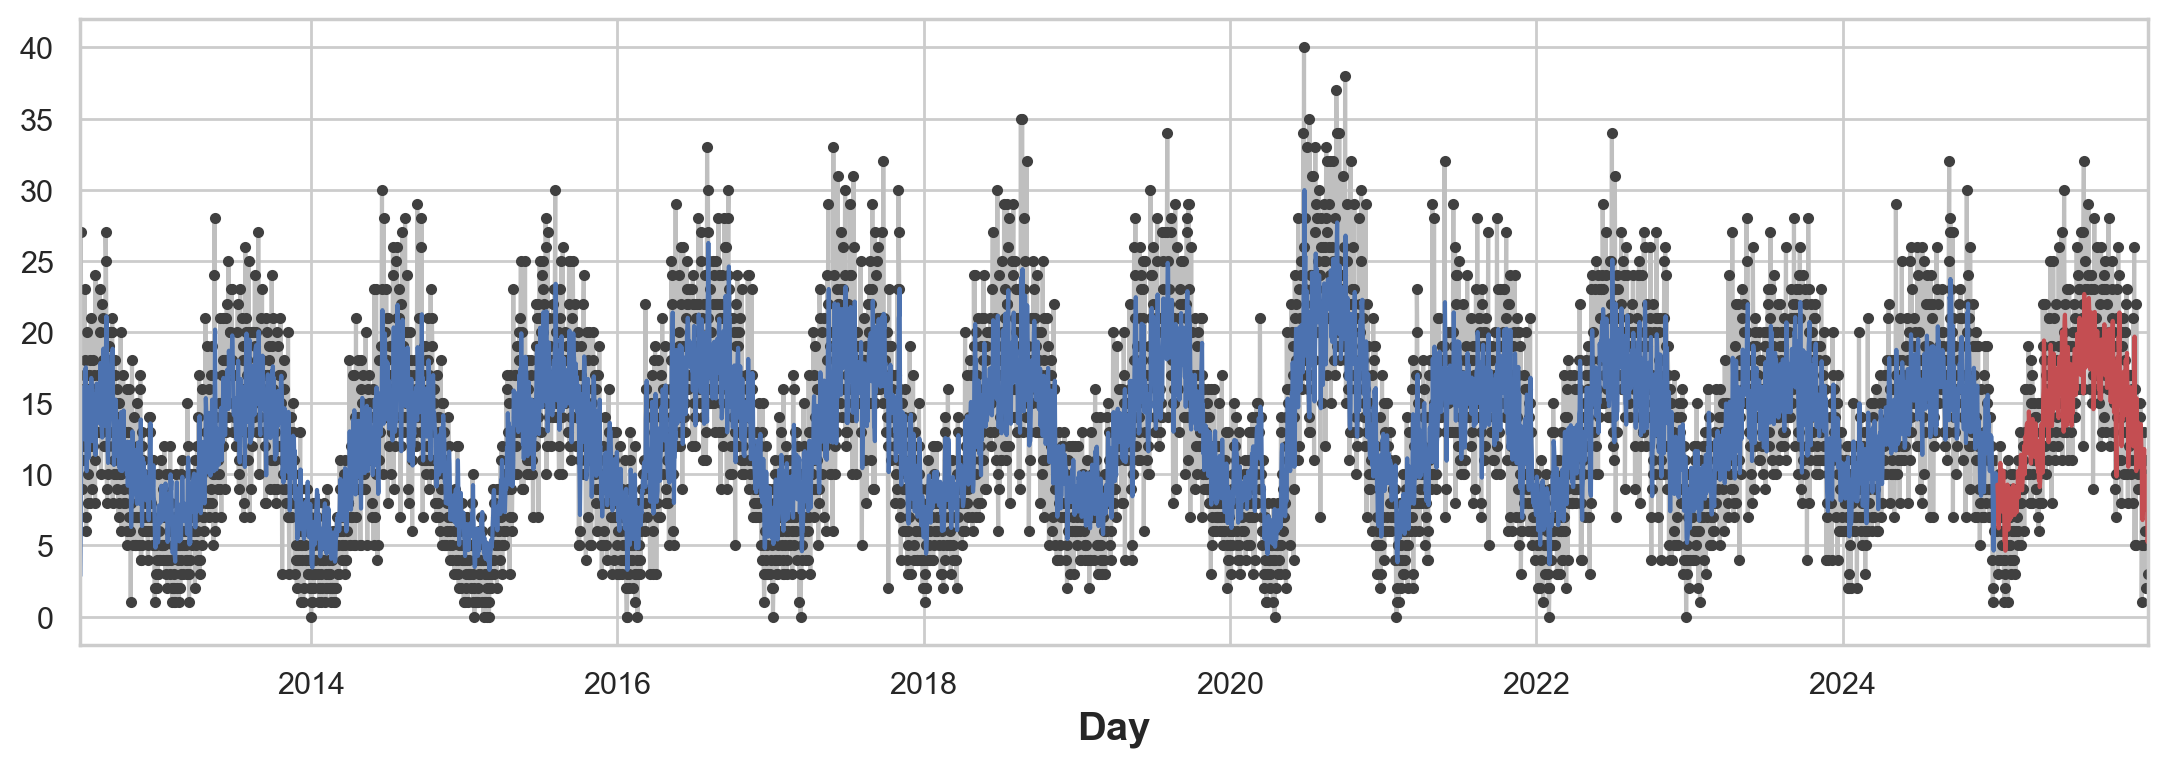

In [43]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

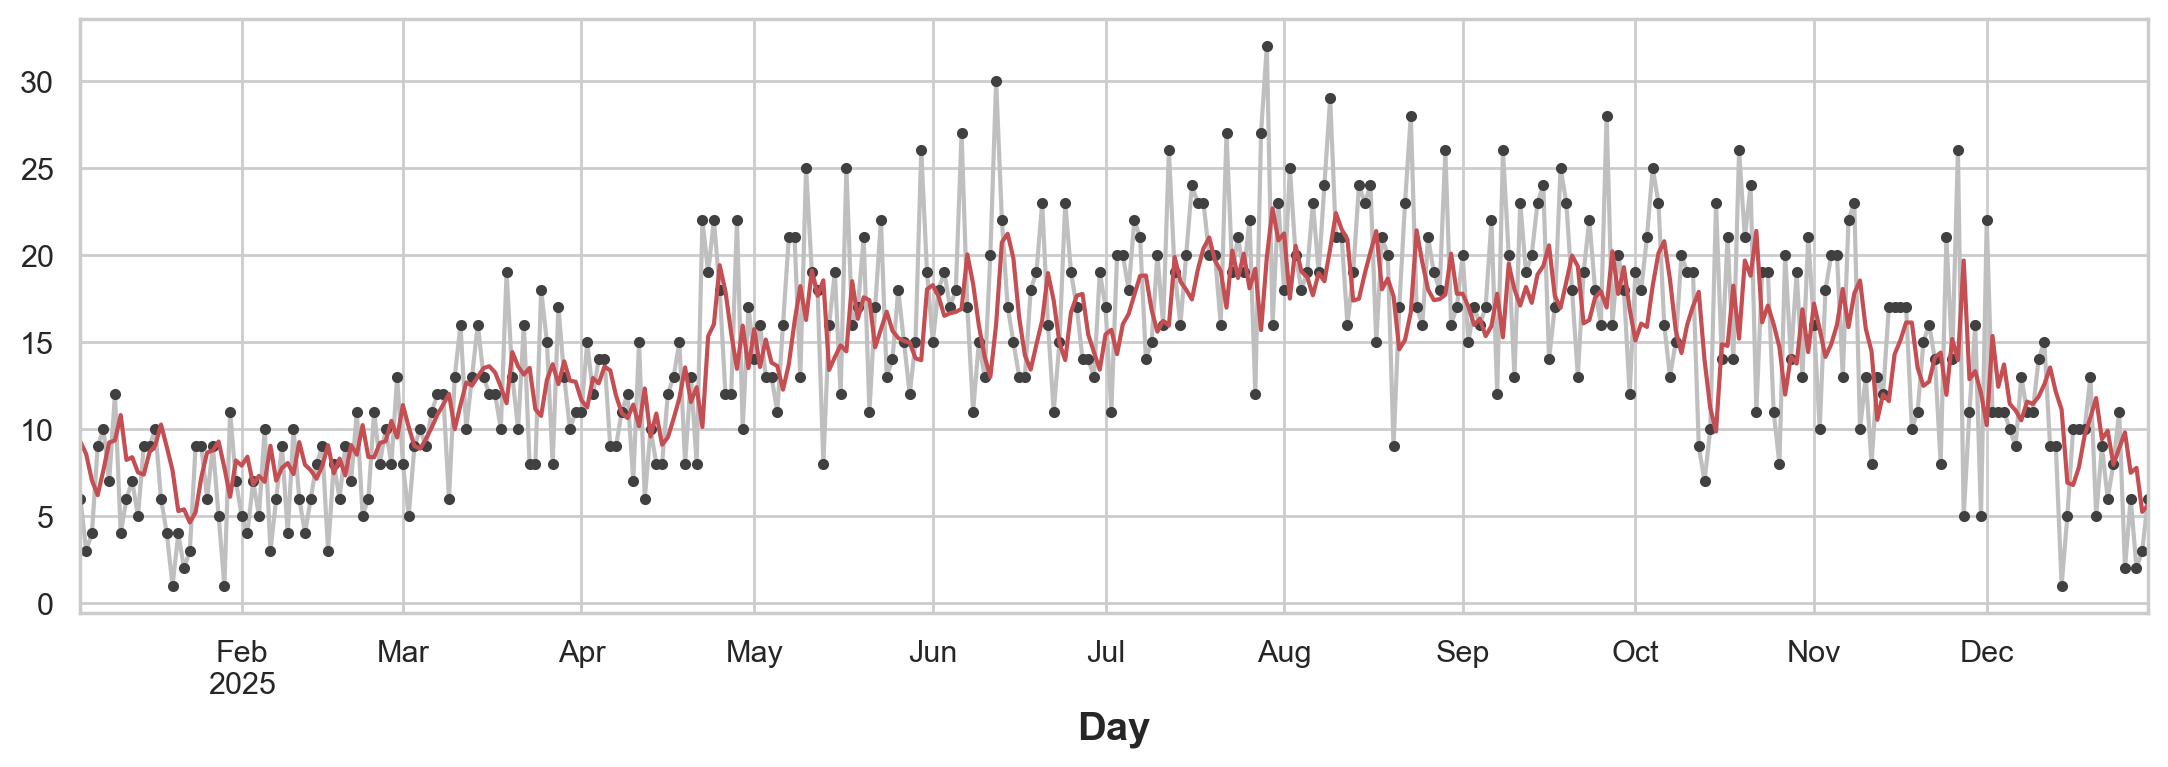

In [44]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

## Time series model

In [45]:
df_daily.head()

,accident_count,Time
Day,,
2012-07-01,9,0
2012-07-02,27,1
2012-07-03,16,2
2012-07-04,9,3
2012-07-05,14,4
